In [ ]:
! pip install langchain_community langchain_chroma langchain_huggingface langchain langgraph langchain_core langchain_groq

In [3]:
! pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 5.4 MB/s eta 0:00:00


In [4]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
from langchain_community.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

In [5]:
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KEY')
huggingface_api_key = userdata.get('HUGGINGFACE_API_KEY')

In [6]:
llm = ChatGroq(model_name='llama-3.1-8b-instant', groq_api_key=groq_api_key, temperature=0) # makes it more deterministic

In [7]:
embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")
embeddings

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, query_encode_kwargs={}, multi_process=False, show_progress=False)

In [9]:
loader = PyPDFLoader('Stock_Market_Performance_2024.pdf')
doc = loader.load()
len(doc) #pages

9

In [10]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = splitter.split_documents(doc)


In [11]:
try:
  vectordb = Chroma.from_documents(
    docs,
    embedding=embeddings,
    persist_directory='./vectordb'
    )
except Exception as e:
  print(f'Error setting up chroma')
  raise

In [12]:
retriever = vectordb.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

In [13]:
@tool
def retriever_tool(query: str)->str:
  """
  This tool searches and returns information for stock market performance 2024
  """
  docs = retriever.invoke(query)
  if not docs:
    return 'I found no such information in stock market performance 2024'
  else:
    result = []
    for i, doc in enumerate(docs):
      result.append(f'Document {i+1}: \n{doc.page_content}')
    return "\n\n".join(result)
tools=[retriever_tool]
llm=llm.bind_tools(tools=tools)

In [14]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

def should_continue(state: AgentState):
  """Check if the last message has tool calls"""
  result = state['messages'][-1]
  return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [15]:
system_prompt="""
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [16]:
tools_dict = {our_tool.name: our_tool for our_tool in tools}

def call_llm(state: AgentState)->AgentState:
  """
  Function calls the LLM with current State
  """
  messages = list(state['messages'])
  messages = [SystemMessage(content=system_prompt)] + messages
  message = llm.invoke(messages)
  return {'messages': [message]}

In [17]:
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")

        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."

        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")


        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [18]:
graph = StateGraph(AgentState)
graph.add_node('llm',call_llm)
graph.add_node('retriever_agent', take_action)
graph.add_conditional_edges(
    'llm', should_continue,
    {
        True: 'retriever_agent',
        False: END
    }
)
graph.add_edge('retriever_agent', 'llm')
graph.add_edge(START, 'llm')
rag_agent = graph.compile()

In [19]:
def run_agent():
  while True:
    user_input = input('Enter a message')
    if user_input.lower() in ['end', 'quit']:
      break
    messages = [HumanMessage(content=user_input)]
    result = rag_agent.invoke({'messages': messages})
    print(result['messages'][-1].content)
run_agent()

Enter a messageHow did apple perform in the market
Calling Tool: retriever_tool with query: apple stock market performance 2024
Result length: 4879
Tools Execution Complete. Back to the model!
Apple performed well in the market in 2024, with its stock price rising approximately 36% over the course of the year, reaching new all-time highs and lifting its market capitalization to nearly $4 trillion by year-end (Document 2). The company's gains were driven by solid demand for its products, continued growth in high-margin services, and expansion into emerging markets (Document 2). However, Apple's valuation expanded to a lofty level, with its P/E ratio reaching around 40 times its trailing earnings, reflecting substantial optimism from investors (Document 3).
Enter a messageHow about Tesla
Calling Tool: retriever_tool with query: Tesla stock market performance 2024
Result length: 4495
Tools Execution Complete. Back to the model!
Tesla's stock experienced a roller-coaster year in 2024, but 

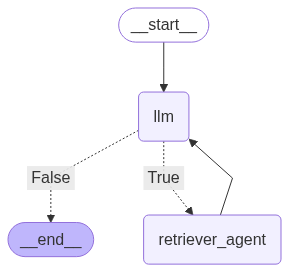

In [20]:
from IPython.display import Image, display
display(Image(rag_agent.get_graph().draw_mermaid_png()))